<a href="https://colab.research.google.com/github/Theophilus-Dwamena/Short-term-Precipitation-Forecasting-Using-Deep-Learning/blob/main/LSTM_Nowcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

In [2]:
# Generate synthetic data
def generate_synthetic_data(samples=1000, timesteps=6, height=64, width=64, channels=1):
    X = np.random.rand(samples, timesteps, height, width, channels)
    y = np.random.rand(samples, height, width, channels)
    return X, y

X_train, y_train = generate_synthetic_data()
X_test, y_test = generate_synthetic_data(samples=200)

In [3]:
# TISE-LSTM Model
def build_tise_lstm():
    inputs = layers.Input(shape=(6, 64, 64, 1))
    x = layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.Reshape((6, -1))(x)
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(64 * 64, activation='sigmoid')(x)
    outputs = layers.Reshape((64, 64, 1))(outputs)
    return models.Model(inputs, outputs)

In [4]:
# ConvLSTM Model
def build_convlstm():
    inputs = layers.Input(shape=(6, 64, 64, 1))
    x = layers.ConvLSTM2D(64, (3, 3), activation='relu', padding='same', return_sequences=False)(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    return models.Model(inputs, outputs)

In [5]:
# Compile and train models
models_dict = {
    'TISE-LSTM': build_tise_lstm(),
    'ConvLSTM': build_convlstm(),
}

for name, model in models_dict.items():
    print(f'Training {name}...')
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test))

Training TISE-LSTM...
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.0833 - val_loss: 0.0833
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 0.0833 - val_loss: 0.0833
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 0.0832 - val_loss: 0.0833
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - loss: 0.0832 - val_loss: 0.0833
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 0.0833 - val_loss: 0.0833
Training ConvLSTM...
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 608s 10s/step - loss: 0.0834 - val_loss: 0.0833
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 623s 10s/step - loss: 0.0834 - val_loss: 0.0833
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 603s 10s/step - loss: 0.0832 - val_loss: 0.0833
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 622s 10s/step - loss: 0.0833 - val_loss: 0.0833
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 609s 10s/step - loss: 0.0833 - val_loss: 0.0833


In [6]:
from skimage.metrics import structural_similarity as ssim

# Evaluate models numerically
def evaluate_model(model, model_name):
    predictions = model.predict(X_test)

    mse_score = np.mean((predictions - y_test) ** 2)
    ssim_score = np.mean([ssim(y_test[i, :, :, 0], predictions[i, :, :, 0], data_range=1.0) for i in range(len(y_test))])

    print(f"{model_name} - MSE: {mse_score:.6f}, SSIM: {ssim_score:.4f}")

for name, model in models_dict.items():
    evaluate_model(model, name)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step
TISE-LSTM - MSE: 0.083316, SSIM: 0.0108
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step
ConvLSTM - MSE: 0.083279, SSIM: 0.0108


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


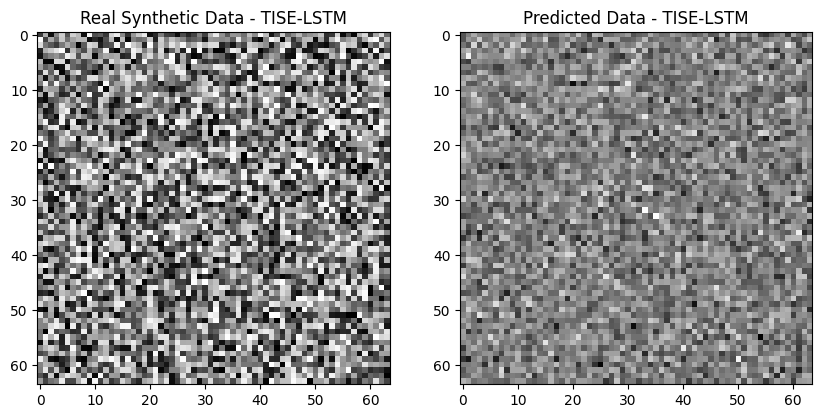

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


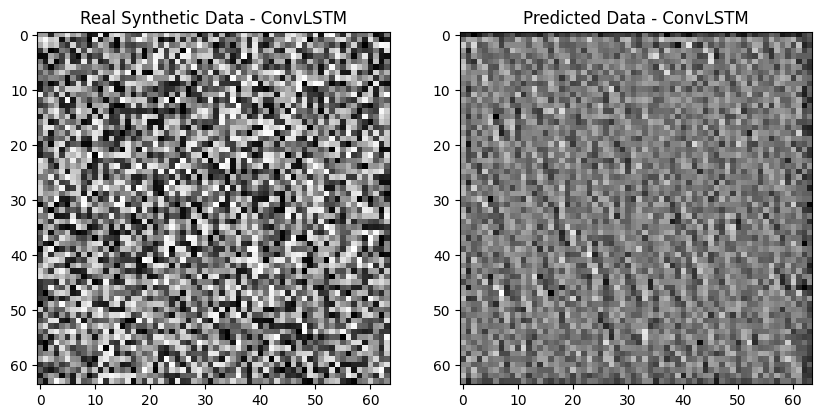

In [7]:
# Plot predictions vs real data
def plot_predictions(model, model_name):
    idx = np.random.randint(0, X_test.shape[0])
    prediction = model.predict(np.expand_dims(X_test[idx], axis=0))[0, :, :, 0]
    real = y_test[idx, :, :, 0]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(real, cmap='gray')
    plt.title(f'Real Synthetic Data - {model_name}')
    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='gray')
    plt.title(f'Predicted Data - {model_name}')
    plt.show()

for name, model in models_dict.items():
    plot_predictions(model, name)